# ERK2 Compounds: Molecular descriptors using RDKit

In [1]:
import pandas as pd
import numpy as np

In [2]:
### Load the data and create the molecules dataframe

In [3]:
# First lets load the data
df_csar = pd.read_json('./CSAR_39mols_used_by_Fourches.json')
df_model = pd.read_json('./CHEMBL4040_47mols_used_by_Fourches_erk2.json')

# For now, we are only interested in Names, SMILES (csar have isomeric smiles) and pKi
df_csar = df_csar[['Name_fourches', 'pKi', 'mol']]
df_model = df_model[['Name_fourches', 'pKi', 'canonical_smiles']]

# Rename the columns to simplify the dataframe
col_names_ = ['Name', 'pKi', 'smiles']
df_csar.columns = col_names_
df_model.columns = col_names_

# Now, concat the dataframes
df_erk2_mols = pd.concat([df_csar, df_model], ignore_index=True)

# Now, let's create a two new columns to account for activity according to Fourches
# Molecules with a pKi >= 7.5 will be considered as actives
df_erk2_mols['activity'] = (df_erk2_mols.pKi >= 7.5).astype(int)
df_erk2_mols['activity_label'] = ['active' if i else 'inactive' for i in df_erk2_mols.activity]

In [4]:
df_erk2_mols.head()

,Name,pKi,smiles,activity,activity_label
0,CSAR_erk2_18,9.00,OC[C@@H](NC(=O)c1[nH]cc(c1)-c1nc(ncc1C)NC(C)C)...,1,active
1,CSAR_erk2_20,8.70,Clc1cc(ccc1)[C@H](NC(=O)c1[nH]cc(c1)-c1nc(ncc1...,1,active
2,CSAR_erk2_17,8.52,Clc1cc(ccc1)[C@H](NC(=O)c1[nH]cc(c1)-c1nc(ncc1...,1,active
3,CSAR_erk2_16,8.40,Clc1cc(ccc1)[C@H](NC(=O)c1[nH]cc(c1)-c1nc(ncc1...,1,active
4,CSAR_erk2_15,8.40,OC[C@@H](NC(=O)c1[nH]cc(c1)-c1nc(ncc1C)NCC)c1c...,1,active


In [5]:
# Save the dataframe
df_erk2_mols.to_json('./ERK2_molecules_used_by_Fourches_SMILES.json')

In [6]:
### Use rdkit to compute molecule rdkit objects

In [7]:
from rdkit import Chem

RDKit WARNING: [20:53:48] Enabling RDKit 2019.09.1 jupyter extensions


In [8]:
# Add the new column with the RDKit molecules
df_erk2_mols['rdk_mol'] = [Chem.MolFromSmiles(i, sanitize=True) for i in df_erk2_mols.smiles]

## MACCS Keys fingerprints

In [9]:
from rdkit.Chem import MACCSkeys

# Compute the fingerprints over the whole set of molecules
df_erk2_mols['maccs'] = [MACCSkeys.GenMACCSKeys(i) for i in df_erk2_mols.rdk_mol]

In [10]:
# Example of MACC Keys Fingepirnt for molecule 1
df_erk2_mols.maccs[0].ToBitString()

'00000000000000000000000001000000000000000000000000000010000000100100000000100101101100000000100110100000101001110000010011000100000101010101011011000111011111111111110'

## 2D-RDKit molecular descriptors

Apparently this set of 117 descriptors is available through KNIME, specifically by the use of "[RDKit Descriptor Calculation](https://nodepit.com/node/org.rdkit.knime.nodes.descriptorcalculation.DescriptorCalculationNodeFactory)" node, which use a java wrapper to execute rdkit inside a KNIME pipeline ([code here](https://github.com/rdkit/knime-rdkit/blob/2616f9fa3c56107825ae26f3435a7733b1658251/org.rdkit.knime.nodes/src/org/rdkit/knime/nodes/descriptorcalculation/Descriptor.java)).

Because all these descriptors are directly available in RDKit's python library, we are going to compute them directly:

In [11]:
# Firts, let's import the available list  of descriptors
from rdkit.Chem import Descriptors
# Get the descriptor names but ommit all descriptors related to fragments inside molecules (all of them start with 'fr_')
names_of_all_rdkit_descriptors = [x[0] for x in Descriptors._descList if x[0][:3] != 'fr_']
# Number of descriptor available:
len(names_of_all_rdkit_descriptors)

115

Now, let's use the 'MolecularDescriptorCalculator' class, which takes a list of rdkit descriptors names and compute them on a given molecule.

In [12]:
from rdkit.ML.Descriptors import MoleculeDescriptors
# rdkit descriptor calculator
rdk_calculator = MoleculeDescriptors.MolecularDescriptorCalculator(names_of_all_rdkit_descriptors)

In [13]:
# Now let's compute the fingerprints over the molecules
df_erk2_mols['2d_rdkit'] = [rdk_calculator.CalcDescriptors(mol = i) for i in df_erk2_mols.rdk_mol]

## WHIM descriptors

In [14]:
from rdkit.Chem import rdMolDescriptors
from glob import glob

The list of WHIM descriptors computed by RDKit is the following:

In [15]:
whim_axial = [ "L1u", "L2u", "L3u", "P1u", "P2u", "G1u", "G2u", "G3u", "E1u", "E2u", "E3u", 
               "L1m", "L2m", "L3m", "P1m", "P2m", "G1m", "G2m", "G3m", "E1m", "E2m", "E3m", 
               "L1v", "L2v", "L3v", "P1v", "P2v", "G1v", "G2v", "G3v", "E1v", "E2v", "E3v", 
               "L1e", "L2e", "L3e", "P1e", "P2e", "G1e", "G2e", "G3e", "E1e", "E2e", "E3e", 
               "L1p", "L2p", "L3p", "P1p", "P2p", "G1p", "G2p", "G3p", "E1p", "E2p", "E3p", 
               "L1i", "L2i", "L3i", "P1i", "P2i", "G1i", "G2i", "G3i", "E1i", "E2i", "E3i", 
               "L1s", "L2s", "L3s", "P1s", "P2s", "G1s", "G2s", "G3s", "E1s", "E2s", "E3s"]
whim_global = ["Tu", "Tm", "Tv", "Te", "Tp", "Ti", "Ts", 
               "Au", "Am", "Av", "Ae", "Ap", "Ai", "As", 
               "Gu", "Gm", 
               "Ku", "Km", "Kv", "Ke", "Kp", "Ki", "Ks", 
               "Du", "Dm", "Dv", "De", "Dp", "Di", "Ds", 
               "Vu", "Vm", "Vv", "Ve", "Vp", "Vi", "Vs"]

whim_descriptors_names = whim_axial + whim_global

In [16]:
print('There are', len(whim_descriptors_names), 'WHIM descriptors.')
len(whim_axial)

There are 114 WHIM descriptors.


77

### About descriptors computed by KNIME
Fourches & Ash indicate that they compute the descriptors using KNIME. We analyze  
**Other notebook**

### Computed from a minimized conformation

In [17]:
# Directory of sdf files: 3D conformations created and minimized using babel
SDF_MIN_DIR = '../../ARCHIVOS/CRISTALES/LIGS_ERK2/FOURCHES_LIGS/3d_minimized/sdf/'

# List of sdf files
sdf_min_files = [SDF_MIN_DIR + i + '.sdf' for i in df_erk2_mols.Name] # keep the same order as the dataframe

# Read the files using RDkit
min_3d_confs = [Chem.SDMolSupplier(mol_file, sanitize=True)[0] for mol_file in sdf_min_files]

# Add minimized confs to the table
df_erk2_mols['conf_3d_min'] = min_3d_confs

# Compute WHIM descriptors for 3d min conformations
df_erk2_mols['whim_3d_min'] = [rdMolDescriptors.CalcWHIM(i) for i in df_erk2_mols.conf_3d_min]

### Computed from the best pose using the 3i60 conformation (the one used by Fourches)

In [18]:
# Directory of sdf files generated from the best docking poses
# Folders inside this directory belong to each ligand
SDF_DOCKED_DIR = '../../ARCHIVOS/CRISTALES/LIGS_ERK2/FOURCHES_LIGS/3d_minimized/docking_results_CRYS_ENS/VINARDO_POSES/SDF/'
pdb_3i60 = '3i60'

# List of sdf files (files are sorted as)
sdf_3i60_files = [glob(SDF_DOCKED_DIR + i + '/*' + pdb_3i60 + '*.sdf')[0] for i in df_erk2_mols.Name]

# Read the files using RDkit
# If  sanitization is not possible (ligs erk2_29 and erk2_12), we need to force rdkit
dk_3i60_confs = []
print('Molecules not sanitized at loading:')
for mol_file in sdf_3i60_files:
    mol_rdk = Chem.SDMolSupplier(mol_file, sanitize = True)[0]
    # If sanitize was not possible, molecule will be == None
    if mol_rdk == None:
        print(mol_file.split('/')[-1])
        mol_rdk  = Chem.SDMolSupplier(mol_file, sanitize = False)[0]
        mol_rdk.UpdatePropertyCache(strict = False)
    # Append  the molecule
    dk_3i60_confs.append(mol_rdk)
    
# Add docked poses to 3i60 confs to the table
df_erk2_mols['conf_3i60_dk_pose'] = dk_3i60_confs

# Compute WHIM descriptors for  3i60 poses
df_erk2_mols['whim_3i60_dk_pose'] = [rdMolDescriptors.CalcWHIM(i) for i in df_erk2_mols.conf_3i60_dk_pose]

Molecules not sanitized at loading:
erk2_29_3i60_dkVin.sdf
erk2_12_3i60_dkVin.sdf


RDKit ERROR: [20:53:51] Explicit valence for atom # 1 C, 6, is greater than permitted
RDKit ERROR: [20:53:51] ERROR: Could not sanitize molecule ending on line 97
RDKit ERROR: [20:53:51] ERROR: Explicit valence for atom # 1 C, 6, is greater than permitted
RDKit ERROR: [20:53:51] Explicit valence for atom # 1 C, 6, is greater than permitted
RDKit ERROR: [20:53:51] ERROR: Could not sanitize molecule ending on line 82


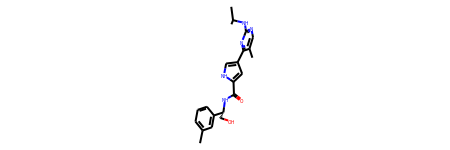

In [19]:
df_erk2_mols['conf_3i60_dk_pose'][0]

## USR or 3D D-MOMENTS 

In [20]:
usr_descriptor_names =  ['Ctd-Mean', 'Ctd-Sigma', 'Ctd-Skewness',
                         'Cst-Mean', 'Cst-Sigma', 'Cst-Skewness', 
                         'Fct-Mean', 'Fct-Sigma', 'Fct-Skewness',
                         'Ftf-Mean', 'Ftf-Sigma', 'Ftf-Skewness']

### Computed for a minimized conformation

In [21]:
# Use the 'conf_3d_min' column computed above
# Compute USR/3-D MOMENTS descriptors for 3d min conformations
df_erk2_mols['dMoments_3d_min'] = [rdMolDescriptors.GetUSR(i) for i in df_erk2_mols.conf_3d_min]

### Computed from the best pose using the 3i60 conformation (the one used by Fourches)

In [22]:
# Compute USR/3-D MOMENTS descriptors for 3i60 poses
df_erk2_mols['dMoments_3i60_dk_pose'] = [rdMolDescriptors.GetUSR(i) for i in df_erk2_mols.conf_3i60_dk_pose]

# 'MD 3D-descriptors' - > '*Ensemble Docking* 3D-descriptors'

## WHIM descriptors

In [23]:
# For each ligand read the 166 poses (one pose per each protein crystal conformation)
SDF_DOCKED_DIR = '../../ARCHIVOS/CRISTALES/LIGS_ERK2/FOURCHES_LIGS/3d_minimized/docking_results_CRYS_ENS/VINARDO_POSES/SDF/'
# list of moleucles paths
mol_dir_paths = SDF_DOCKED_DIR + df_erk2_mols.Name
# List of pdb_ids
pdb_ids = pd.read_json('../data/TABLA_MTDATA_ERK2_166_crys_LIGS_INFO.json').index.values

#### Get a dataframe with all ligand poses in all protein crystals

In [24]:
import pickle, os

file_ = 'df_all_mols_all_dk_poses_crys.pickle'
if os.path.isfile(file_):
    # read the table of all ligand poses in all protein crystals
    with open(file_, 'rb') as f:
        df_all_mols_all_dk_poses_crys = pickle.load(f)
else:
    mol_dict_poses = {}
    for mol_name, path in zip(df_erk2_mols.Name, mol_dir_paths):
        # List of molecule poses per pdb id
        mol_pdb_list = []
        for pdb_id in pdb_ids:
            # Get the molecule sdf docking pose filename
            mol_file = glob( path + '/*' + pdb_id + '*.sdf')[0]
            # Read the molecule
            mol_pdbid_rdk = Chem.SDMolSupplier(mol_file, sanitize = True)[0]
            if mol_pdbid_rdk == None:
                mol_pdbid_rdk = Chem.SDMolSupplier(mol_file, sanitize = False)[0]
                mol_pdbid_rdk.UpdatePropertyCache(strict = False)
            # Append the molecule pose
            mol_pdb_list.append(mol_pdbid_rdk)
        # Add the molecule with all its poses to the dictionary
        mol_dict_poses[mol_name] = mol_pdb_list

    # Create a dataframe with all the poses for each molecule
    df_all_mols_all_dk_poses_crys = pd.DataFrame.from_dict(mol_dict_poses, orient='index', columns=pdb_ids)

    # save the dataframe as a pickle file
    with open(file_, 'wb') as f:
        pickle.dump(df_all_mols_all_dk_poses_crys, f)

#### Create a dictionary of data frames
Each data frame belongs to one molecule. Rows are protein crstal conformations (pdb ids) and columns are the 114 WHIM descriptors.

In [25]:
# Funtion to simplify the calculation with future descriptors
def calc_poses_3d_descriptors(rdk_descriptor, descriptor_names, index_names):
    dict_descriptors_per_mol = {}

    for mol, row_mol in df_all_mols_all_dk_poses_crys.iterrows():
        mtx_descriptors = [rdk_descriptor(pdb_id_pose) for pdb_id_pose in row_mol]
        # Conver to a dataframe
        df_descriptors = pd.DataFrame(mtx_descriptors, index=index_names, columns=descriptor_names)
        # add to the dictionary
        dict_descriptors_per_mol[mol] = df_descriptors
    return dict_descriptors_per_mol

### Calc WHIM

In [26]:
dict_all_mols_poses_WHIM = calc_poses_3d_descriptors(rdk_descriptor = rdMolDescriptors.CalcWHIM, 
                              descriptor_names = whim_descriptors_names,
                              index_names = pdb_ids)

### Calc USR/D-MOMENTS

In [27]:
dict_all_mols_poses_MOMENTS = calc_poses_3d_descriptors(rdk_descriptor = rdMolDescriptors.GetUSR, 
                                  descriptor_names = usr_descriptor_names,
                                  index_names = pdb_ids)

### COMPUTE 3D-Descriptors (mean and standard deviation)

In [ ]:
### MD-3D WHIM means  and std

In [33]:
# MD-3D WHIM means  and std

# Create the columns
df_erk2_mols['whim_3d_ESNDK_mean'] = [df.mean(axis=0).values for key, df in dict_all_mols_poses_WHIM.items()]
df_erk2_mols['whim_3d_ESNDK_std'] = [df.std(axis=0).values for key, df in dict_all_mols_poses_WHIM.items()]


#### MD-3D D-MOMENS means  and std

In [34]:
# MD-3D D-MOMENS means  and std
df_erk2_mols['dMoments_3d_ESNDK_mean'] = [df.mean(axis=0).values for key, df in dict_all_mols_poses_MOMENTS.items()]
df_erk2_mols['dMoments_3d_ESNDK_std'] = [df.std(axis=0).values for key, df in dict_all_mols_poses_MOMENTS.items()]

,Name,pKi,smiles,activity,activity_label,rdk_mol,maccs,2d_rdkit,conf_3d_min,whim_3d_min,conf_3i60_dk_pose,whim_3i60_dk_pose,dMoments_3d_min,dMoments_3i60_dk_pose,whim_3d_ESNDK_mean,whim_3d_ESNDK_std
0,CSAR_erk2_18,9.00,OC[C@@H](NC(=O)c1[nH]cc(c1)-c1nc(ncc1C)NC(C)C)...,1,active,<rdkit.Chem.rdchem.Mol object at 0x7f8a33ca4670>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","(12.715656406884762, -0.4752029268497526, 12.7...",<rdkit.Chem.rdchem.Mol object at 0x7f8a31b1d260>,"[20.124, 2.731, 1.335, 0.832, 0.113, 0.171, 0....",<rdkit.Chem.rdchem.Mol object at 0x7f8a64b81170>,"[23.08, 1.846, 1.444, 0.875, 0.07, 0.171, 0.17...","[4.572691741947685, 1.8111024894054373, 0.6384...","[4.6845909475098, 2.103468303308349, -0.428104...","[20.53726506024097, 2.835765060240964, 1.12196...","[2.3362110380198433, 0.7558074704232369, 0.440..."
1,CSAR_erk2_20,8.70,Clc1cc(ccc1)[C@H](NC(=O)c1[nH]cc(c1)-c1nc(ncc1...,1,active,<rdkit.Chem.rdchem.Mol object at 0x7f8a33ca4620>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","(12.732601425250234, -0.5842611122540919, 12.7...",<rdkit.Chem.rdchem.Mol object at 0x7f8a31b1d2b0>,"[21.998, 3.024, 1.325, 0.835, 0.115, 0.168, 0....",<rdkit.Chem.rdchem.Mol object at 0x7f8a64b81080>,"[18.375, 4.232, 1.178, 0.773, 0.178, 0.168, 0....","[4.733135802783101, 1.985858807320014, -0.7893...","[4.589756035032674, 1.6489105850364187, 0.6805...","[22.5528734939759, 3.1145421686747, 1.19980722...","[2.910871162262799, 0.8694993725225373, 0.4508..."
2,CSAR_erk2_17,8.52,Clc1cc(ccc1)[C@H](NC(=O)c1[nH]cc(c1)-c1nc(ncc1...,1,active,<rdkit.Chem.rdchem.Mol object at 0x7f8a33ca45d0>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","(12.673356705323695, -3.485752224368547, 12.67...",<rdkit.Chem.rdchem.Mol object at 0x7f8a31b1d300>,"[25.471, 3.081, 0.833, 0.867, 0.105, 0.168, 0....",<rdkit.Chem.rdchem.Mol object at 0x7f8a64b81670>,"[20.911, 4.467, 1.201, 0.787, 0.168, 0.168, 0....","[4.920328013510791, 2.2750238299519183, -0.646...","[4.828073108005295, 1.8080725950927654, 0.6057...","[22.24037349397591, 3.3985240963855414, 1.1990...","[3.5417783162523016, 0.9869677081807705, 0.444..."
3,CSAR_erk2_16,8.40,Clc1cc(ccc1)[C@H](NC(=O)c1[nH]cc(c1)-c1nc(ncc1...,1,active,<rdkit.Chem.rdchem.Mol object at 0x7f8a33ca46c0>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","(12.773794968174546, -0.5775077495754046, 12.7...",<rdkit.Chem.rdchem.Mol object at 0x7f8a31b1d350>,"[23.064, 4.183, 0.819, 0.822, 0.149, 0.167, 0....",<rdkit.Chem.rdchem.Mol object at 0x7f8a64b81d50>,"[24.643, 3.584, 1.189, 0.838, 0.122, 0.167, 0....","[4.91868004698112, 1.9679634600018558, -0.7830...","[5.0430204627064406, 1.9960941855257577, 0.664...","[23.018192771084344, 3.55871686746988, 1.24806...","[4.218193660389892, 1.160659942088254, 0.46732..."
4,CSAR_erk2_15,8.40,OC[C@@H](NC(=O)c1[nH]cc(c1)-c1nc(ncc1C)NCC)c1c...,1,active,<rdkit.Chem.rdchem.Mol object at 0x7f8a33ca4710>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","(12.672667426168507, -0.4719507076884424, 12.6...",<rdkit.Chem.rdchem.Mol object at 0x7f8a31b1d3a0>,"[19.599, 2.321, 0.927, 0.858, 0.102, 0.172, 0....",<rdkit.Chem.rdchem.Mol object at 0x7f8a64b81f30>,"[21.164, 1.835, 1.526, 0.863, 0.075, 0.172, 0....","[4.377438043471682, 1.9195276382878705, -0.445...","[4.5254275245217865, 2.0112695080660177, -0.49...","[19.34016867469879, 2.709927710843373, 1.10342...","[1.8686322226424403, 0.6753138580421839, 0.379..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81,erk2_05,5.33,CCOc1nc(NC(=O)Cc2cc(OC)ccc2OC)cc(N)c1C#N,0,inactive,<rdkit.Chem.rdchem.Mol object at 0x7f8a33ca6f80>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","(12.390455876795162, -0.3235100151171575, 12.3...",<rdkit.Chem.rdchem.Mol object at 0x7f8a31b19c10>,"[13.115, 2.91, 1.434, 0.751, 0.167, 0.175, 0.1...",<rdkit.Chem.rdchem.Mol object at 0x7f8a64b8b670>,"[16.286, 2.491, 0.282, 0.854, 0.131, 0.175, 0....","[3.9600740368671854, 1.3329605599323524, -0.57...","[3.9857859806548452, 1.78110068509306, 0.57803.

In [30]:
df_erk2_mols

,Name,pKi,smiles,activity,activity_label,rdk_mol,maccs,2d_rdkit,conf_3d_min,whim_3d_min,conf_3i60_dk_pose,whim_3i60_dk_pose,dMoments_3d_min,dMoments_3i60_dk_pose,whim_3d_ESNDK_mean,whim_3d_ESNDK_std
0,CSAR_erk2_18,9.00,OC[C@@H](NC(=O)c1[nH]cc(c1)-c1nc(ncc1C)NC(C)C)...,1,active,<rdkit.Chem.rdchem.Mol object at 0x7f8a33ca4670>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","(12.715656406884762, -0.4752029268497526, 12.7...",<rdkit.Chem.rdchem.Mol object at 0x7f8a31b1d260>,"[20.124, 2.731, 1.335, 0.832, 0.113, 0.171, 0....",<rdkit.Chem.rdchem.Mol object at 0x7f8a64b81170>,"[23.08, 1.846, 1.444, 0.875, 0.07, 0.171, 0.17...","[4.572691741947685, 1.8111024894054373, 0.6384...","[4.6845909475098, 2.103468303308349, -0.428104...",None,None
1,CSAR_erk2_20,8.70,Clc1cc(ccc1)[C@H](NC(=O)c1[nH]cc(c1)-c1nc(ncc1...,1,active,<rdkit.Chem.rdchem.Mol object at 0x7f8a33ca4620>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","(12.732601425250234, -0.5842611122540919, 12.7...",<rdkit.Chem.rdchem.Mol object at 0x7f8a31b1d2b0>,"[21.998, 3.024, 1.325, 0.835, 0.115, 0.168, 0....",<rdkit.Chem.rdchem.Mol object at 0x7f8a64b81080>,"[18.375, 4.232, 1.178, 0.773, 0.178, 0.168, 0....","[4.733135802783101, 1.985858807320014, -0.7893...","[4.589756035032674, 1.6489105850364187, 0.6805...",None,None
2,CSAR_erk2_17,8.52,Clc1cc(ccc1)[C@H](NC(=O)c1[nH]cc(c1)-c1nc(ncc1...,1,active,<rdkit.Chem.rdchem.Mol object at 0x7f8a33ca45d0>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","(12.673356705323695, -3.485752224368547, 12.67...",<rdkit.Chem.rdchem.Mol object at 0x7f8a31b1d300>,"[25.471, 3.081, 0.833, 0.867, 0.105, 0.168, 0....",<rdkit.Chem.rdchem.Mol object at 0x7f8a64b81670>,"[20.911, 4.467, 1.201, 0.787, 0.168, 0.168, 0....","[4.920328013510791, 2.2750238299519183, -0.646...","[4.828073108005295, 1.8080725950927654, 0.6057...",None,None
3,CSAR_erk2_16,8.40,Clc1cc(ccc1)[C@H](NC(=O)c1[nH]cc(c1)-c1nc(ncc1...,1,active,<rdkit.Chem.rdchem.Mol object at 0x7f8a33ca46c0>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","(12.773794968174546, -0.5775077495754046, 12.7...",<rdkit.Chem.rdchem.Mol object at 0x7f8a31b1d350>,"[23.064, 4.183, 0.819, 0.822, 0.149, 0.167, 0....",<rdkit.Chem.rdchem.Mol object at 0x7f8a64b81d50>,"[24.643, 3.584, 1.189, 0.838, 0.122, 0.167, 0....","[4.91868004698112, 1.9679634600018558, -0.7830...","[5.0430204627064406, 1.9960941855257577, 0.664...",None,None
4,CSAR_erk2_15,8.40,OC[C@@H](NC(=O)c1[nH]cc(c1)-c1nc(ncc1C)NCC)c1c...,1,active,<rdkit.Chem.rdchem.Mol object at 0x7f8a33ca4710>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","(12.672667426168507, -0.4719507076884424, 12.6...",<rdkit.Chem.rdchem.Mol object at 0x7f8a31b1d3a0>,"[19.599, 2.321, 0.927, 0.858, 0.102, 0.172, 0....",<rdkit.Chem.rdchem.Mol object at 0x7f8a64b81f30>,"[21.164, 1.835, 1.526, 0.863, 0.075, 0.172, 0....","[4.377438043471682, 1.9195276382878705, -0.445...","[4.5254275245217865, 2.0112695080660177, -0.49...",None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81,erk2_05,5.33,CCOc1nc(NC(=O)Cc2cc(OC)ccc2OC)cc(N)c1C#N,0,inactive,<rdkit.Chem.rdchem.Mol object at 0x7f8a33ca6f80>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","(12.390455876795162, -0.3235100151171575, 12.3...",<rdkit.Chem.rdchem.Mol object at 0x7f8a31b19c10>,"[13.115, 2.91, 1.434, 0.751, 0.167, 0.175, 0.1...",<rdkit.Chem.rdchem.Mol object at 0x7f8a64b8b670>,"[16.286, 2.491, 0.282, 0.854, 0.131, 0.175, 0....","[3.9600740368671854, 1.3329605599323524, -0.57...","[3.9857859806548452, 1.78110068509306, 0.57803...",None,None
82,erk2_04,5.24,CCOc1nc(NC(=O)Cc2cc(OC)c(S(C)(=O)=O)cc2OC)cc(N...,0,inactive,<rdkit.Chem.rdchem.Mol object at 0x7f8a33ca7030>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","(12.55403907627866, -3.5633053589628267, 12.55...",<rdkit.Chem.rdchem.Mol object at 0x7f8a31b19c60>,"[16.769, 4.047, 0.505, 0.786, 0.19, 0.169, 0.1...",<rdkit.Chem.rdchem.Mol object at 0x7f8a64b8b6c0>,"[18.032, 3.381, 0.397, 0.827, 0.155, 0.169, 0....","[4.355309621871675, 1.5